经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 本教程使用PaddlePaddle建立起一个房价预测模型。

在线性回归中：

（1）假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。 在本次线性回顾模型中，我们的假设函数为 Y’= wX+b ，其中，Y’表示模型的预测结果（预测房价），用来和真实的Y区分。模型要学习的参数即：w,b。

（2）损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。 建立模型后，我们需要给模型一个优化目标，使得学到的参数能够让预测值Y’尽可能地接近真实值Y。这个实值通常用来反映模型误差的大小。不同问题场景下采用不同的损失函数。 对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。

（3）优化算法：神经网络的训练就是调整权重（参数）使得损失函数值尽可能得小，在训练过程中，将损失函数值逐渐收敛，得到一组使得神经网络拟合真实模型的权重（参数）。所以，优化算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量w和b的值，一步一步地试出这个最小值。 常见的优化算法有随机梯度下降法（SGD）、Adam算法等等

**首先导入必要的包**，分别是：

**paddle.fluid**--->PaddlePaddle深度学习框架

**numpy**---------->python基本库，用于科学计算

**os**------------------>python的模块，可使用该模块对操作系统进行操作

**matplotlib**----->python绘图库，可方便绘制折线图、散点图等图形

In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

根据14列原始开始数据处理。

In [2]:
import numpy as np
import json
# 读入训练数据
datafile = 'data/data49217/housing.data'
data = np.fromfile(datafile, sep=' ')
print(data)

[6.320e-03 1.800e+01 2.310e+00 ... 3.969e+02 7.880e+00 1.190e+01]


In [3]:
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])

# 查看数据
x = data[0]
print(x.shape)
print(x)

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


In [4]:
#数据集划分
print(data.shape)
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
print(training_data.shape)

(506, 14)
(404, 14)


In [5]:
#数据归一化处理
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

In [6]:
#获取数据
test_data = data[offset:]
x = training_data[:, :-1]
y = training_data[:, -1:]
# 查看数据
print(x[0])
print(y[0])

[0.         0.18       0.07344184 0.         0.31481481 0.57750527
 0.64160659 0.26920314 0.         0.22755741 0.28723404 1.
 0.08967991]
[0.42222222]


In [7]:
#模型设计
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost

In [8]:
#测试一条数据
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[2.39362982]


In [9]:
#训练配置，定义损失函数
Loss = (y1 - z)*(y1 - z)
print(Loss)

[3.88644793]


In [10]:
#计算多个样本预测值和损失函数
# 此处可以一次性计算多个样本的预测值和损失函数
net = Network(13)
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print('predict: ', z)
loss = net.loss(z, y1)
print('loss:', loss)

predict:  [[2.39362982]
 [2.46752393]
 [2.02483479]]
loss: 3.384496992612791


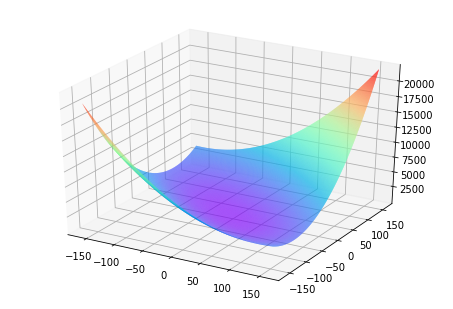

In [11]:
net = Network(13)
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5), len(w9)])

#计算设定区域内每个参数取值所对应的Loss
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#使用matplotlib将两个变量和对应的Loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)

ax.plot_surface(w5, w9, losses, rstride=1, cstride=1, cmap='rainbow')
plt.show()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
z = net.forward(x)
gradient_w = (z - y) * x
print('gradient_w shape {}'.format(gradient_w.shape))
print(gradient_w)

gradient_w shape (404, 13)
[[0.00000000e+00 2.34805180e+01 9.58029163e+00 ... 3.74689117e+01
  1.30447322e+02 1.16985043e+01]
 [2.54738434e-02 0.00000000e+00 2.83333765e+01 ... 5.97311025e+01
  1.07975454e+02 2.20777626e+01]
 [3.07963708e-02 0.00000000e+00 3.42860463e+01 ... 7.22802431e+01
  1.29029688e+02 8.29246719e+00]
 ...
 [3.97706874e+01 0.00000000e+00 1.74130673e+02 ... 2.01043762e+02
  2.48659390e+02 1.27554582e+02]
 [2.69696515e+01 0.00000000e+00 1.75225687e+02 ... 2.02308019e+02
  2.34270491e+02 1.28287658e+02]
 [6.08972123e+01 0.00000000e+00 1.53017134e+02 ... 1.76666981e+02
  2.18509161e+02 1.08772220e+02]]


In [13]:
# axis = 0 表示把每一行做相加然后再除以总的行数
gradient_w = np.mean(gradient_w, axis=0)
print('gradient_w ', gradient_w.shape)
print('w ', net.w.shape)
print(gradient_w)
print(net.w)

gradient_w  (13,)
w  (13, 1)
[  4.6555403   19.35268996  55.88081118  14.00266972  47.98588869
  76.87210821  94.8555119   36.07579608  45.44575958  59.65733292
  83.65114918 134.80387478  38.93998153]
[[ 1.76405235e+00]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 [ 2.24089320e+00]
 [ 1.86755799e+00]
 [ 1.59000000e+02]
 [ 9.50088418e-01]
 [-1.51357208e-01]
 [-1.03218852e-01]
 [ 1.59000000e+02]
 [ 1.44043571e-01]
 [ 1.45427351e+00]
 [ 7.61037725e-01]]


In [36]:
#转置
gradient_w = gradient_w[:, np.newaxis]
print('gradient_w shape', gradient_w.shape)
print(gradient_w)

gradient_w shape (13, 1)
[[  4.6555403 ]
 [ 19.35268996]
 [ 55.88081118]
 [ 14.00266972]
 [ 47.98588869]
 [ 76.87210821]
 [ 94.8555119 ]
 [ 36.07579608]
 [ 45.44575958]
 [ 59.65733292]
 [ 83.65114918]
 [134.80387478]
 [ 38.93998153]]


In [37]:
#计算标量
gradient_b = (z - y)
gradient_b = np.mean(gradient_b)
# 此处b是一个数值，所以可以直接用np.mean得到一个标量
gradient_b

142.50289323156107

In [38]:
#完整网络函数
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        
        return gradient_w, gradient_b

In [39]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络
net = Network(13)
# 设置[w5, w9] = [-100., -100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))


point [-100.0, -100.0], loss 7873.345739941161
gradient [-45.87968288123223, -35.50236884482904]


In [41]:
# 在[w5, w9]平面上，沿着梯度的反方向移动到下一个点P1
# 定义移动步长 eta
eta = 0.1
# 更新参数w5和w9
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
# 重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))


point [-95.41203171187678, -96.4497631155171], loss 7214.694816482369
gradient [-43.883932999069096, -34.019273908495926]


In [42]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights,1)
        self.w[5] = -100.
        self.w[9] = -100.
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
        
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        for i in range(iterations):
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        return points, losses

iter 0, point [-99.54120317118768, -99.64497631155172], loss 7873.345739941161
iter 50, point [-78.9761810944732, -83.65939206734069], loss 5131.480704109405
iter 100, point [-62.4493631356931, -70.67918223434114], loss 3346.754494352463
iter 150, point [-49.17799206644332, -60.12620415441553], loss 2184.906016270654
iter 200, point [-38.53070194231174, -51.533984751788346], loss 1428.4172504483342
iter 250, point [-29.998249130283174, -44.52613603923428], loss 935.7392894242679
iter 300, point [-23.169901624519575, -38.79894318028118], loss 614.7592258739251
iter 350, point [-17.71439280083778, -34.10731848231335], loss 405.53408184471505
iter 400, point [-13.364557220746388, -30.253470630210863], loss 269.0551396220099
iter 450, point [-9.904936677384967, -27.077764259976597], loss 179.9364750604248
iter 500, point [-7.161782280775628, -24.451346444229817], loss 121.65711285489998
iter 550, point [-4.994989383373879, -22.270198517465555], loss 83.46491706360901
iter 600, point [-3.29

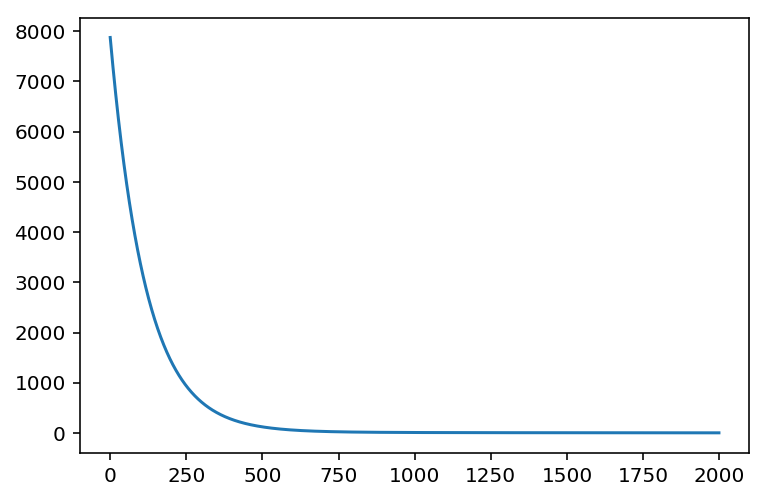

In [43]:

# 创建网络
net = Network(13)
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()
%matplotlib inline

iter 9, loss 5.143394325795511
iter 19, loss 3.097924194225988
iter 29, loss 2.082241020617026
iter 39, loss 1.5673801618157397
iter 49, loss 1.2966204735077431
iter 59, loss 1.1453399043319765
iter 69, loss 1.0530155717435201
iter 79, loss 0.9902292156463155
iter 89, loss 0.9426576903842504
iter 99, loss 0.9033048096880774
iter 109, loss 0.868732003041364
iter 119, loss 0.837229250968144
iter 129, loss 0.807927474161227
iter 139, loss 0.7803677341465797
iter 149, loss 0.7542920908532763
iter 159, loss 0.7295420168915829
iter 169, loss 0.7060090054240882
iter 179, loss 0.6836105084697767
iter 189, loss 0.6622781710179412
iter 199, loss 0.6419520361168637
iter 209, loss 0.622577651786949
iter 219, loss 0.6041045903195837
iter 229, loss 0.5864856570315078
iter 239, loss 0.5696764374763879
iter 249, loss 0.5536350125932015
iter 259, loss 0.5383217588525027
iter 269, loss 0.5236991929680567
iter 279, loss 0.509731841376165
iter 289, loss 0.4963861247069634
iter 299, loss 0.4836302523439023

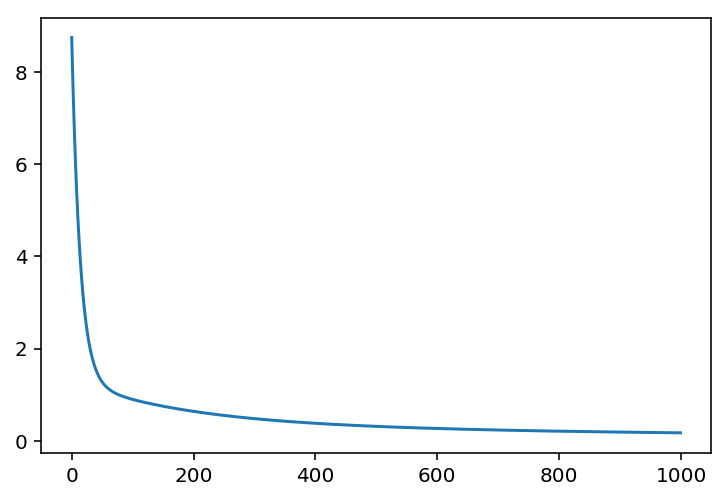

In [44]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses


# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [4]:
import numpy as np
def load_data():
    # 从文件导入数据
    datafile = 'data/data49217/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

Epoch   0 / iter   0, loss = 1.0281
Epoch   0 / iter   1, loss = 0.5048
Epoch   0 / iter   2, loss = 0.6382
Epoch   0 / iter   3, loss = 0.5168
Epoch   0 / iter   4, loss = 0.1951
Epoch   1 / iter   0, loss = 0.6281
Epoch   1 / iter   1, loss = 0.4611
Epoch   1 / iter   2, loss = 0.4520
Epoch   1 / iter   3, loss = 0.3961
Epoch   1 / iter   4, loss = 0.1381
Epoch   2 / iter   0, loss = 0.5642
Epoch   2 / iter   1, loss = 0.4250
Epoch   2 / iter   2, loss = 0.4480
Epoch   2 / iter   3, loss = 0.3881
Epoch   2 / iter   4, loss = 0.1884
Epoch   3 / iter   0, loss = 0.3921
Epoch   3 / iter   1, loss = 0.5582
Epoch   3 / iter   2, loss = 0.3759
Epoch   3 / iter   3, loss = 0.3849
Epoch   3 / iter   4, loss = 0.1425
Epoch   4 / iter   0, loss = 0.3821
Epoch   4 / iter   1, loss = 0.4382
Epoch   4 / iter   2, loss = 0.3864
Epoch   4 / iter   3, loss = 0.4314
Epoch   4 / iter   4, loss = 0.0471
Epoch   5 / iter   0, loss = 0.4264
Epoch   5 / iter   1, loss = 0.3829
Epoch   5 / iter   2, loss =

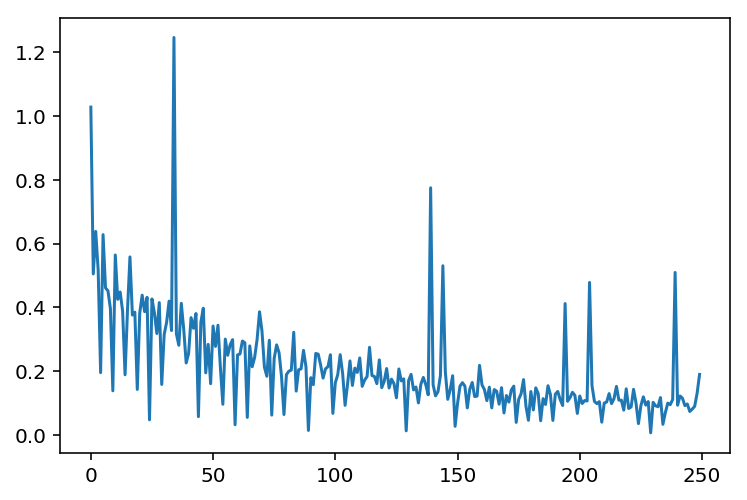

In [7]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
import matplotlib.pyplot as plt
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [8]:
g5 = net.w[5][0]
g9 = net.w[9][0]
print(g5,g9)

0.019825351039066793 0.26431525325205585


In [9]:
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值

w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5), len(w9)])

#计算设定区域内每个参数取值所对应的Loss
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#使用matplotlib将两个变量和对应的Loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)

ax.plot_surface(w5, w9, losses, 
rstride=1,                      # rstride（row）指定行的跨度
cstride=1,                      # cstride(column)指定列的跨度
cmap='rainbow')                 # 设置颜色映射
ax.scatter(g5, g9, 1, c='r')
plt.show()
plt.savefig('image/loss_surface.jpg')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# **Step1：准备数据。**

（1）uci-housing数据集介绍

数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。

PaddlePaddle提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。

(2)train_reader和test_reader

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [11]:
import paddle
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  
    

(3)打印看下数据是什么样的？PaddlePaddle接口提供的数据已经经过归一化等处理

(array([-0.02964322, -0.11363636,  0.39417967, -0.06916996,  0.14260276,
       -0.10109875,  0.30715859, -0.13176829, -0.24127857,  0.05489093,
        0.29196451, -0.2368098 ,  0.12850267]), array([15.6])),

In [7]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

# **Step2:网络配置**

**（1）网络搭建**：对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

![](https://ai-studio-static-online.cdn.bcebos.com/f3f567e7aa7a499fb3abb767aaaa1b943eed373cf4694d87beb382e161ea8edc)

![](https://ai-studio-static-online.cdn.bcebos.com/f6c44a96e1624828829bbd438c29c17ead9ecc45c68b4310bfbbb0a4dc96c3fe)


In [11]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

In [15]:
print (y.shape)

**(2)定义损失函数**

此处使用均方差损失函数。

square_error_cost(input,lable):接受输入预测值和目标值，并返回方差估计,即为（y-y_predict）的平方

In [11]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

**(3)定义优化函数**

此处使用的是随机梯度下降。

In [12]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [13]:
test_program = fluid.default_main_program().clone(for_test=True)

在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入**fluid.default_startup_program()**

**fluid.default_main_program**()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

# **Step3.模型训练** and **Step4.模型评估**

**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [14]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

**（2）定义输入数据维度**

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [15]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [16]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**（4）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

注：enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，

In [17]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)


# **Step5.模型预测**

**（1）创建预测用的Executor**

In [18]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [19]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

In [20]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)

****